# OBIETTIVO: core value analysis



In [73]:
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import tucker
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.tenalg import mode_dot, multi_mode_dot
import kagglehub
import h5py
from tqdm import tqdm
import pandas as pd
import kagglehub
import global_variables

In [74]:
n_snapshots = 200
subsample_x = 10
subsample_y = 10
paths = ["sharmapushan/hydrogen-jet-10000"]
data_paths = [kagglehub.dataset_download(name) for name in paths]
with open(data_paths[0] + '/info.json') as f:
    metadata = json.load(f)
Nx, Ny = metadata['global']['Nxyz']
Nx_sub = Nx // subsample_x
Ny_sub = Ny // subsample_y
component_names = global_variables.component_names
n_species = global_variables.n_species
molar_masses = global_variables.molar_masses
file_key_map = global_variables.file_key_map
Lx, Ly = global_variables.Lx, global_variables.Ly


In [75]:
tensors = {}
for data_path in data_paths:
    key = data_path.split('/')[-3]
    print(f"{key}")
    tensor = np.zeros((Ny//subsample_y, Nx//subsample_x, n_species, n_snapshots))
    for t_idx in range(n_snapshots):
        for new_idx, (comp_name, orig_idx) in enumerate(zip(component_names, range(n_species))):
            filename_key = file_key_map[comp_name]
            filename = metadata['local'][t_idx][filename_key]
            data = np.fromfile(f"{data_path}/{filename}", dtype='<f4').reshape(Ny, Nx)
            molar_data = data / molar_masses[comp_name]
            tensor[:, :, new_idx, t_idx] = molar_data[::subsample_x, ::subsample_y]
    tensors[key] = tensor
            

hydrogen-jet-10000


In [76]:
def scale_and_center_tensors(tensors, component_names, log_scale=True, temporal_m = False, std_scale = True, epsilon=1e-12):
    tensors_scaled = {}
    
    for dataset_path, tensor in tensors.items():
        tensor_scaled = tensor.copy()
        
        for c_idx, comp_name in enumerate(component_names):
            component_data = tensor_scaled[:, :, c_idx, :]
            
            if log_scale:
                component_data = np.log10(np.maximum(component_data, epsilon))
            
            mean_val = component_data.mean()
            std_val = component_data.std()    
            if std_val < epsilon:
                std_val = epsilon  # prevent divide-by-zero
            if not std_scale:
                std_val = 1.0
            component_data_scaled = (component_data - mean_val) / std_val
            
            tensor_scaled[:, :, c_idx, :] = component_data_scaled
            if temporal_m:
                temporal_mean = tensor_scaled.mean(axis=3, keepdims=True)
                tensor_scaled = tensor_scaled - temporal_mean
        
        
        tensors_scaled[dataset_path] = tensor_scaled
    return tensors_scaled

In [77]:
tensor_std = scale_and_center_tensors(tensors, component_names, log_scale=True, temporal_m=False, std_scale=True)
tensors_scaled_nostd = scale_and_center_tensors(tensors, component_names, log_scale=True, temporal_m=False, std_scale=False)


In [78]:
decomposition_results = {}  # store factors and cores per dataset

# HOSVD for non-standard scaled tensors
for dataset_path, tensor in tensors_scaled_nostd.items():
    print("\n" + "=" * 100)
    print(f"Performing HOSVD for dataset (no std scale): {dataset_path}")
    print("=" * 100)
    print(f"Tensor shape: (Ny={tensor.shape[0]}, Nx={tensor.shape[1]}, n_chem={tensor.shape[2]}, n_time={tensor.shape[3]})")
    
    # Compute factor matrices for each mode
    print("Computing U_y (mode 0: spatial Y)...")
    U_y, _, _ = np.linalg.svd(tl.unfold(tensor, mode=0), full_matrices=False)
    
    print("Computing U_x (mode 1: spatial X)...")
    U_x, _, _ = np.linalg.svd(tl.unfold(tensor, mode=1), full_matrices=False)
    
    print("Computing U_chem (mode 2: chemical)...")
    U_chem, _, _ = np.linalg.svd(tl.unfold(tensor, mode=2), full_matrices=False)
    
    print("Computing U_time (mode 3: time)...")
    U_time, _, _ = np.linalg.svd(tl.unfold(tensor, mode=3), full_matrices=False)
    
    # Compute core tensor
    print("Computing core tensor...")
    core = multi_mode_dot(tensor, [U_y.T, U_x.T, U_chem.T, U_time.T], modes=[0, 1, 2, 3])
    
    decomposition_results[dataset_path + "_nostd"] = {
        "core": core,
        "U_y": U_y,
        "U_x": U_x,
        "U_chem": U_chem,
        "U_time": U_time,
        "factors": [U_y, U_x, U_chem, U_time],  # Keep for backward compatibility
    }

# HOSVD for standard scaled tensors
for dataset_path, tensor in tensor_std.items():
    print("\n" + "=" * 100)
    print(f"Performing HOSVD for dataset (with std scale): {dataset_path}")
    print("=" * 100)
    print(f"Tensor shape: (Ny={tensor.shape[0]}, Nx={tensor.shape[1]}, n_chem={tensor.shape[2]}, n_time={tensor.shape[3]})")
    
    # Compute factor matrices for each mode
    print("Computing U_y (mode 0: spatial Y)...")
    U_y, _, _ = np.linalg.svd(tl.unfold(tensor, mode=0), full_matrices=False)
    
    print("Computing U_x (mode 1: spatial X)...")
    U_x, _, _ = np.linalg.svd(tl.unfold(tensor, mode=1), full_matrices=False)
    
    print("Computing U_chem (mode 2: chemical)...")
    U_chem, _, _ = np.linalg.svd(tl.unfold(tensor, mode=2), full_matrices=False)
    
    print("Computing U_time (mode 3: time)...")
    U_time, _, _ = np.linalg.svd(tl.unfold(tensor, mode=3), full_matrices=False)
    
    # Compute core tensor
    print("Computing core tensor...")
    core = multi_mode_dot(tensor, [U_y.T, U_x.T, U_chem.T, U_time.T], modes=[0, 1, 2, 3])
    
    decomposition_results[dataset_path + "_std"] = {
        "core": core,
        "U_y": U_y,
        "U_x": U_x,
        "U_chem": U_chem,
        "U_time": U_time,
        "factors": [U_y, U_x, U_chem, U_time],  # Keep for backward compatibility
    }


Performing HOSVD for dataset (no std scale): hydrogen-jet-10000
Tensor shape: (Ny=200, Nx=160, n_chem=8, n_time=200)
Computing U_y (mode 0: spatial Y)...
Computing U_x (mode 1: spatial X)...
Computing U_chem (mode 2: chemical)...
Computing U_time (mode 3: time)...
Computing core tensor...

Performing HOSVD for dataset (with std scale): hydrogen-jet-10000
Tensor shape: (Ny=200, Nx=160, n_chem=8, n_time=200)
Computing U_y (mode 0: spatial Y)...
Computing U_x (mode 1: spatial X)...
Computing U_chem (mode 2: chemical)...
Computing U_time (mode 3: time)...
Computing core tensor...


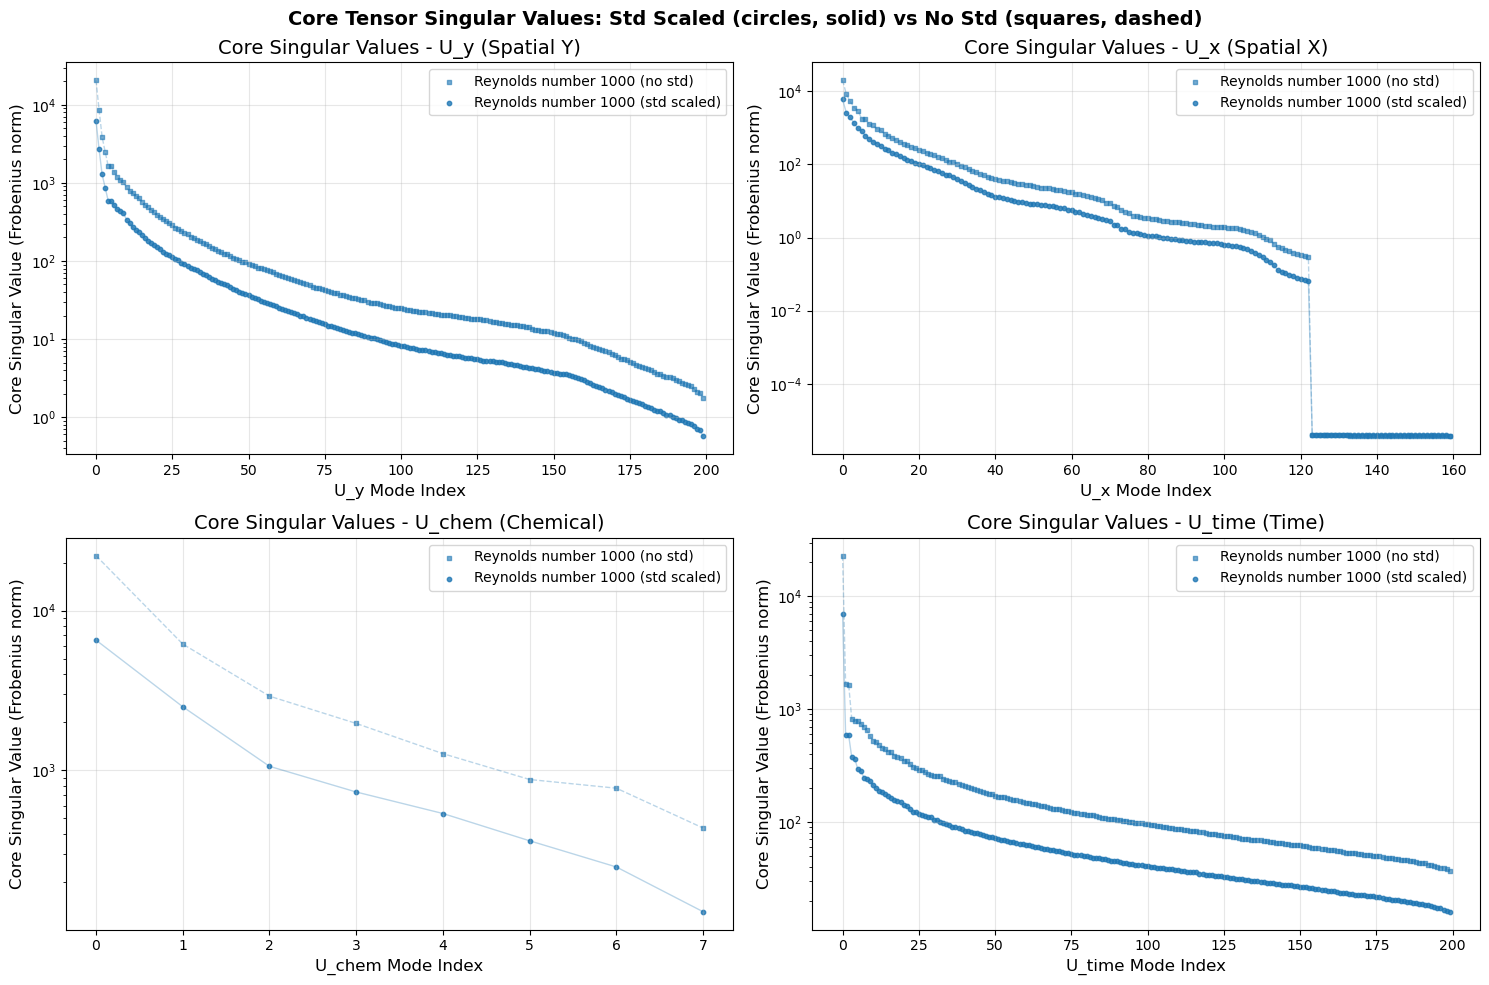

In [79]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Group results by dataset (ignoring _std/_nostd suffix)
dataset_groups = {}
for key in decomposition_results.keys():
    base_key = key.replace('_std', '').replace('_nostd', '')
    if base_key not in dataset_groups:
        dataset_groups[base_key] = {}
    if '_std' in key:
        dataset_groups[base_key]['std'] = decomposition_results[key]
    else:
        dataset_groups[base_key]['nostd'] = decomposition_results[key]

colors = plt.cm.tab10(np.linspace(0, 1, len(dataset_groups)))

for idx, (base_key, variants) in enumerate(dataset_groups.items()):
    dataset_name = f"Reynolds number {base_key.split('-')[-1][:4]}"
    color = colors[idx]
    
    # Plot both std and nostd variants
    for variant_name, variant_data in variants.items():
        core = variant_data['core']
        
        # Use different markers and line styles for std vs nostd
        if variant_name == 'std':
            marker = 'o'
            linestyle = '-'
            alpha_scatter = 0.8
            alpha_line = 0.3
            label = f"{dataset_name} (std scaled)"
        else:
            marker = 's'
            linestyle = '--'
            alpha_scatter = 0.6
            alpha_line = 0.3
            label = f"{dataset_name} (no std)"
        
        # Spatial Y dimension (U_y)
        sv_y = [np.linalg.norm(core[i, :, :, :]) for i in range(core.shape[0])]
        ax = axes[0, 0]
        ax.scatter(range(len(sv_y)), sv_y, color=color, s=10, alpha=alpha_scatter, 
                   label=label, marker=marker)
        ax.plot(range(len(sv_y)), sv_y, color=color, alpha=alpha_line, 
                linewidth=1, linestyle=linestyle)
        
        # Spatial X dimension (U_x)
        sv_x = [np.linalg.norm(core[:, i, :, :]) for i in range(core.shape[1])]
        ax = axes[0, 1]
        ax.scatter(range(len(sv_x)), sv_x, color=color, s=10, alpha=alpha_scatter, 
                   label=label, marker=marker)
        ax.plot(range(len(sv_x)), sv_x, color=color, alpha=alpha_line, 
                linewidth=1, linestyle=linestyle)
        
        # Chemical dimension (U_chem)
        sv_chem = [np.linalg.norm(core[:, :, i, :]) for i in range(core.shape[2])]
        ax = axes[1, 0]
        ax.scatter(range(len(sv_chem)), sv_chem, color=color, s=10, alpha=alpha_scatter, 
                   label=label, marker=marker)
        ax.plot(range(len(sv_chem)), sv_chem, color=color, alpha=alpha_line, 
                linewidth=1, linestyle=linestyle)
        
        # Time dimension (U_time)
        sv_time = [np.linalg.norm(core[:, :, :, i]) for i in range(core.shape[3])]
        ax = axes[1, 1]
        ax.scatter(range(len(sv_time)), sv_time, color=color, s=10, alpha=alpha_scatter, 
                   label=label, marker=marker)
        ax.plot(range(len(sv_time)), sv_time, color=color, alpha=alpha_line, 
                linewidth=1, linestyle=linestyle)

ax = axes[0, 0]
ax.set_xlabel('U_y Mode Index', fontsize=12)
ax.set_ylabel('Core Singular Value (Frobenius norm)', fontsize=12)
ax.set_title('Core Singular Values - U_y (Spatial Y)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=10, loc='best')

ax = axes[0, 1]
ax.set_xlabel('U_x Mode Index', fontsize=12)
ax.set_ylabel('Core Singular Value (Frobenius norm)', fontsize=12)
ax.set_title('Core Singular Values - U_x (Spatial X)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=10, loc='best')

ax = axes[1, 0]
ax.set_xlabel('U_chem Mode Index', fontsize=12)
ax.set_ylabel('Core Singular Value (Frobenius norm)', fontsize=12)
ax.set_title('Core Singular Values - U_chem (Chemical)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=10, loc='best')

ax = axes[1, 1]
ax.set_xlabel('U_time Mode Index', fontsize=12)
ax.set_ylabel('Core Singular Value (Frobenius norm)', fontsize=12)
ax.set_title('Core Singular Values - U_time (Time)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=10, loc='best')

fig.suptitle('Core Tensor Singular Values: Std Scaled (circles, solid) vs No Std (squares, dashed)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()

plt.show()

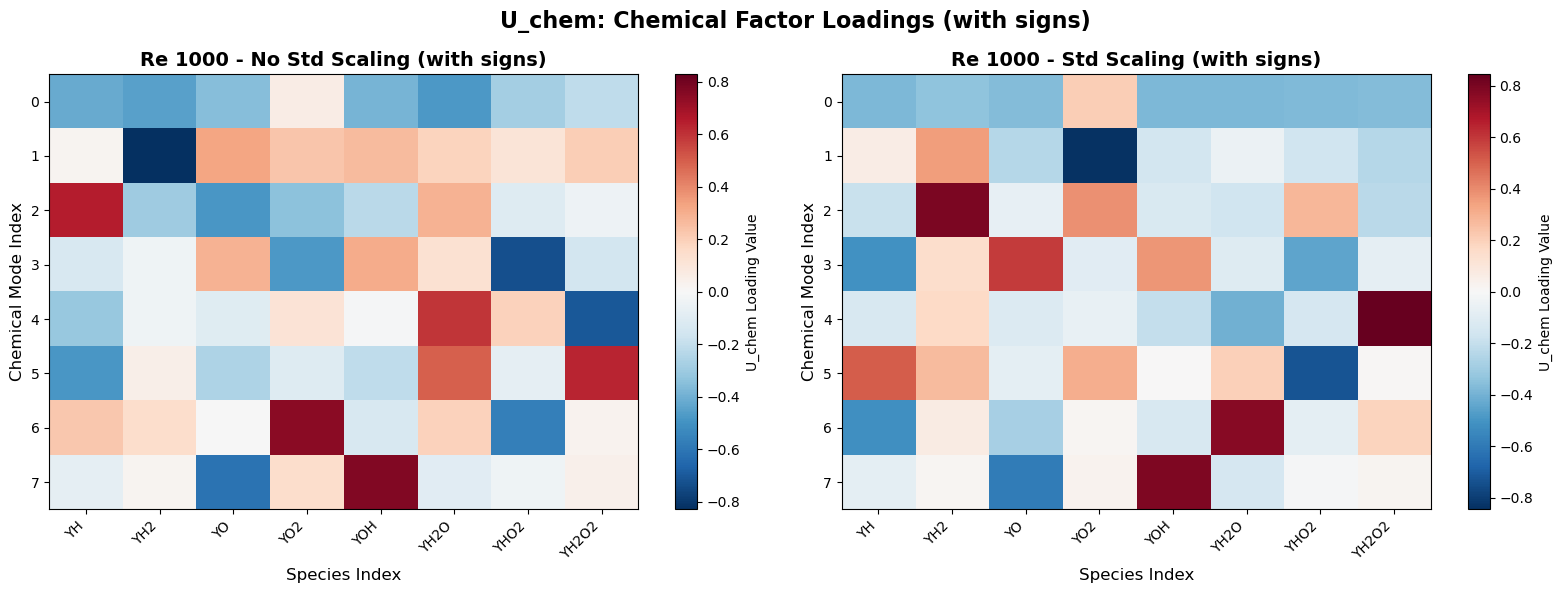

In [80]:
# Visualize Chemical Loadings with Signs
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (base_key, variants) in enumerate(dataset_groups.items()):
    dataset_name = f"Re {base_key.split('-')[-1][:4]}"
    
    # Get U_chem for both variants
    if 'nostd' in variants:
        U_chem_nostd = variants['nostd']['U_chem']  # shape: (n_species, n_species)
        # Plot with signs
        ax = axes[0]
        im0 = ax.imshow(U_chem_nostd.T, cmap='RdBu_r', aspect='auto', 
                        vmin=-np.abs(U_chem_nostd).max(), 
                        vmax=np.abs(U_chem_nostd).max())
        ax.set_xlabel('Species Index', fontsize=12)
        ax.set_ylabel('Chemical Mode Index', fontsize=12)
        ax.set_title(f'{dataset_name} - No Std Scaling (with signs)', fontsize=14, fontweight='bold')
        ax.set_xticks(range(len(component_names)))
        ax.set_xticklabels(component_names, rotation=45, ha='right')
        plt.colorbar(im0, ax=ax, label='U_chem Loading Value')
    
    if 'std' in variants:
        U_chem_std = variants['std']['U_chem']
        # Plot with signs
        ax = axes[1]
        im1 = ax.imshow(U_chem_std.T, cmap='RdBu_r', aspect='auto',
                        vmin=-np.abs(U_chem_std).max(), 
                        vmax=np.abs(U_chem_std).max())
        ax.set_xlabel('Species Index', fontsize=12)
        ax.set_ylabel('Chemical Mode Index', fontsize=12)
        ax.set_title(f'{dataset_name} - Std Scaling (with signs)', fontsize=14, fontweight='bold')
        ax.set_xticks(range(len(component_names)))
        ax.set_xticklabels(component_names, rotation=45, ha='right')
        plt.colorbar(im1, ax=ax, label='U_chem Loading Value')

fig.suptitle('U_chem: Chemical Factor Loadings (with signs)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

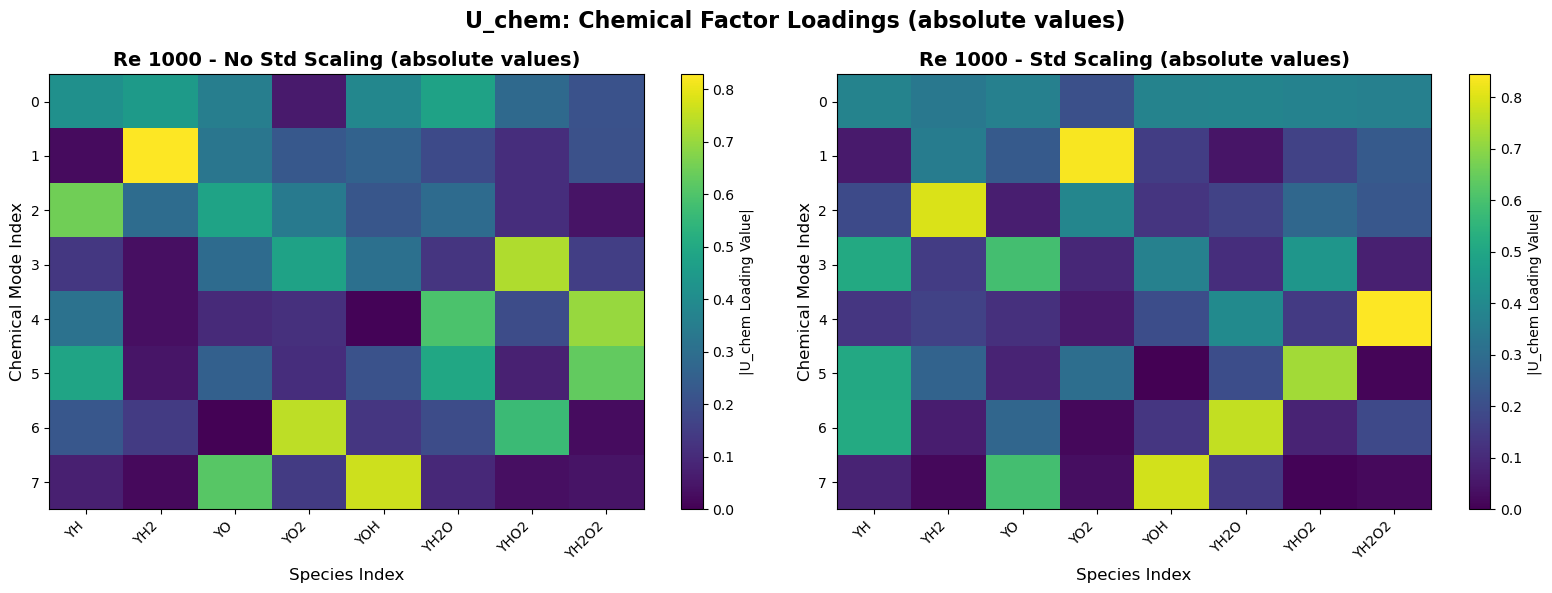

In [81]:
# Visualize Chemical Loadings without Signs (Absolute Values)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (base_key, variants) in enumerate(dataset_groups.items()):
    dataset_name = f"Re {base_key.split('-')[-1][:4]}"
    
    # Get U_chem for both variants
    if 'nostd' in variants:
        U_chem_nostd = np.abs(variants['nostd']['U_chem'])  # Absolute values
        # Plot without signs
        ax = axes[0]
        im0 = ax.imshow(U_chem_nostd.T, cmap='viridis', aspect='auto', 
                        vmin=0, vmax=U_chem_nostd.max())
        ax.set_xlabel('Species Index', fontsize=12)
        ax.set_ylabel('Chemical Mode Index', fontsize=12)
        ax.set_title(f'{dataset_name} - No Std Scaling (absolute values)', fontsize=14, fontweight='bold')
        ax.set_xticks(range(len(component_names)))
        ax.set_xticklabels(component_names, rotation=45, ha='right')
        plt.colorbar(im0, ax=ax, label='|U_chem Loading Value|')
    
    if 'std' in variants:
        U_chem_std = np.abs(variants['std']['U_chem'])  # Absolute values
        # Plot without signs
        ax = axes[1]
        im1 = ax.imshow(U_chem_std.T, cmap='viridis', aspect='auto',
                        vmin=0, vmax=U_chem_std.max())
        ax.set_xlabel('Species Index', fontsize=12)
        ax.set_ylabel('Chemical Mode Index', fontsize=12)
        ax.set_title(f'{dataset_name} - Std Scaling (absolute values)', fontsize=14, fontweight='bold')
        ax.set_xticks(range(len(component_names)))
        ax.set_xticklabels(component_names, rotation=45, ha='right')
        plt.colorbar(im1, ax=ax, label='|U_chem Loading Value|')

fig.suptitle('U_chem: Chemical Factor Loadings (absolute values)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

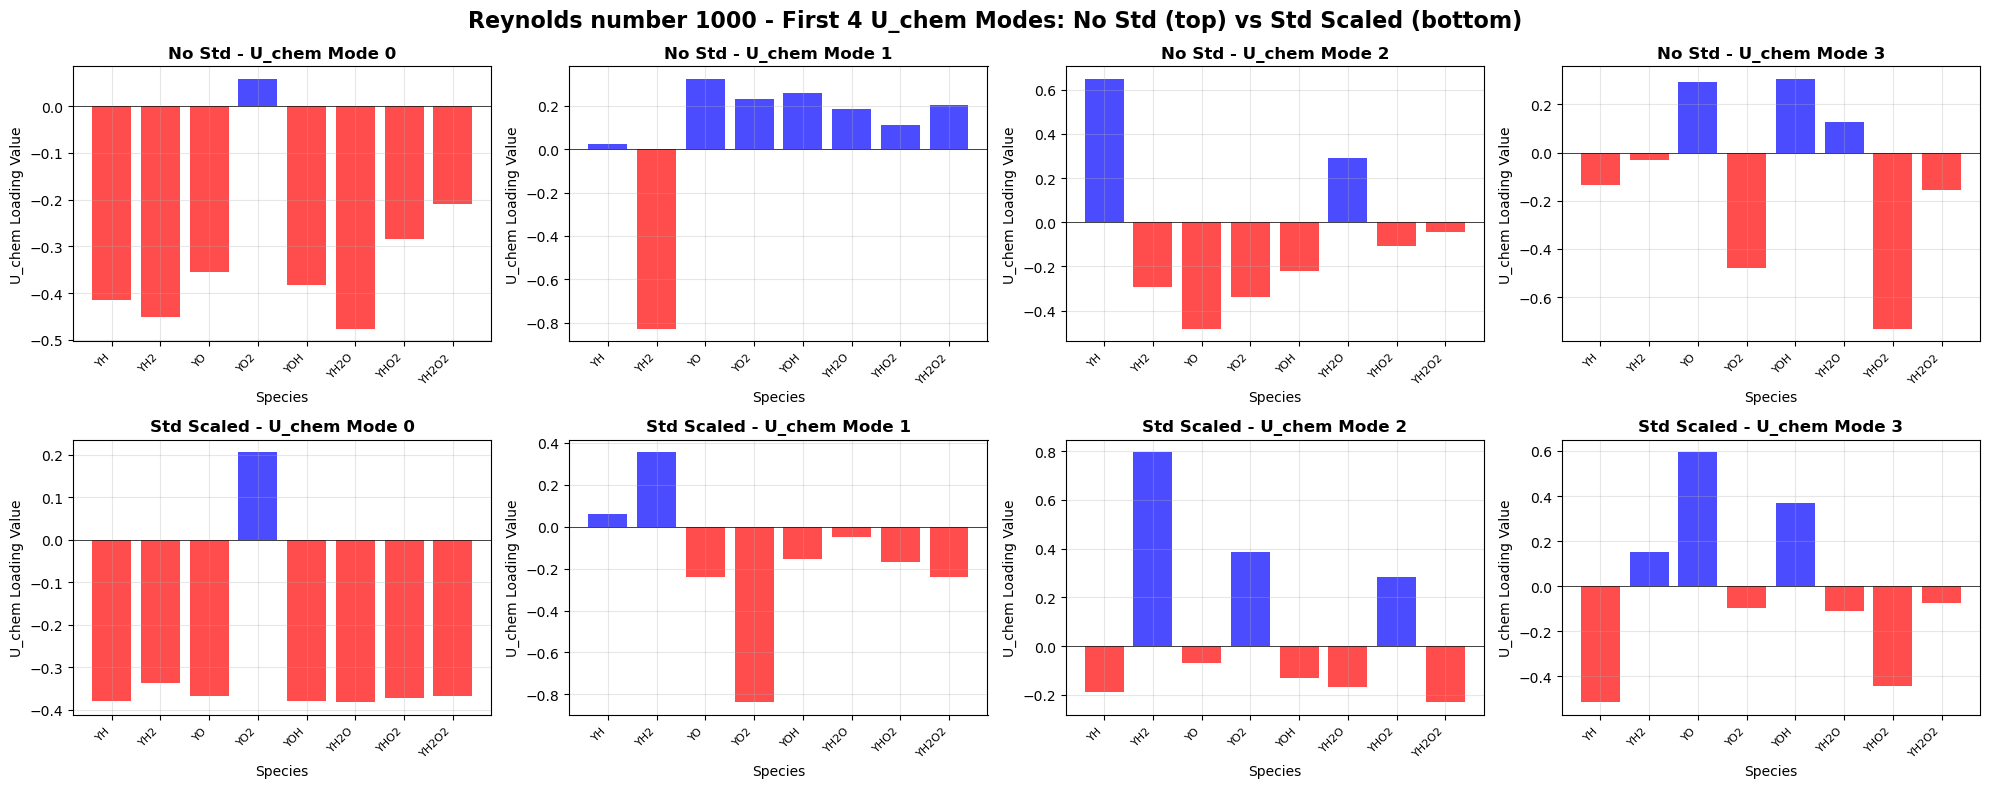

In [82]:
# Visualize first few chemical modes as bar plots for detailed comparison
n_modes_to_show = min(4, len(component_names))

for idx, (base_key, variants) in enumerate(dataset_groups.items()):
    dataset_name = f"Reynolds number {base_key.split('-')[-1][:4]}"
    
    fig, axes = plt.subplots(2, n_modes_to_show, figsize=(20, 8))
    
    if 'nostd' in variants and 'std' in variants:
        U_chem_nostd = variants['nostd']['U_chem']
        U_chem_std = variants['std']['U_chem']
        
        x = np.arange(len(component_names))
        
        for mode_idx in range(n_modes_to_show):
            # No Std Scaling
            ax_nostd = axes[0, mode_idx] if n_modes_to_show > 1 else axes[0]
            values_nostd = U_chem_nostd[:, mode_idx]
            colors_nostd = ['red' if v < 0 else 'blue' for v in values_nostd]
            ax_nostd.bar(x, values_nostd, color=colors_nostd, alpha=0.7)
            ax_nostd.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
            ax_nostd.set_xlabel('Species', fontsize=10)
            ax_nostd.set_ylabel('U_chem Loading Value', fontsize=10)
            ax_nostd.set_title(f'No Std - U_chem Mode {mode_idx}', fontsize=12, fontweight='bold')
            ax_nostd.set_xticks(x)
            ax_nostd.set_xticklabels(component_names, rotation=45, ha='right', fontsize=8)
            ax_nostd.grid(True, alpha=0.3)
            
            # Std Scaling
            ax_std = axes[1, mode_idx] if n_modes_to_show > 1 else axes[1]
            values_std = U_chem_std[:, mode_idx]
            colors_std = ['red' if v < 0 else 'blue' for v in values_std]
            ax_std.bar(x, values_std, color=colors_std, alpha=0.7)
            ax_std.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
            ax_std.set_xlabel('Species', fontsize=10)
            ax_std.set_ylabel('U_chem Loading Value', fontsize=10)
            ax_std.set_title(f'Std Scaled - U_chem Mode {mode_idx}', fontsize=12, fontweight='bold')
            ax_std.set_xticks(x)
            ax_std.set_xticklabels(component_names, rotation=45, ha='right', fontsize=8)
            ax_std.grid(True, alpha=0.3)
        
        fig.suptitle(f'{dataset_name} - First {n_modes_to_show} U_chem Modes: No Std (top) vs Std Scaled (bottom)', 
                     fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

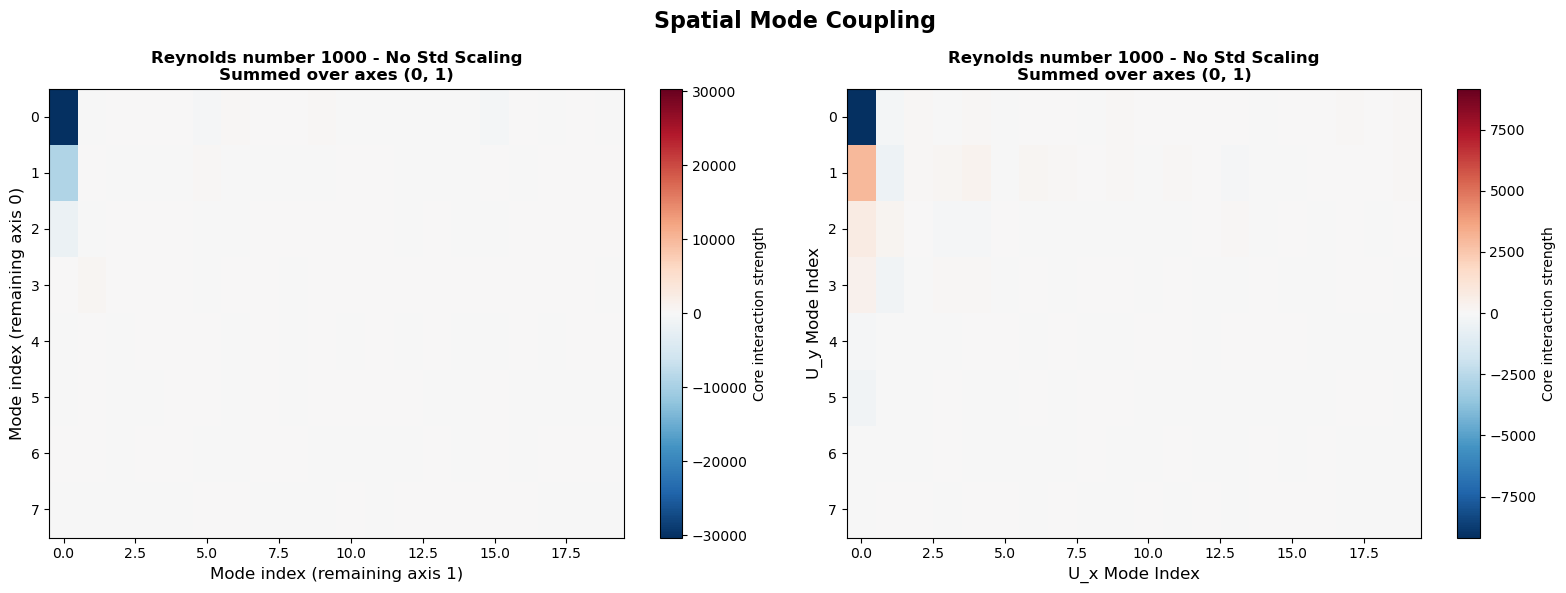

In [83]:
for idx, (base_key, variants) in enumerate(dataset_groups.items()):
    sum_axes = (0, 1)

    dataset_name = f"Reynolds number {base_key.split('-')[-1][:4]}"
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if 'nostd' in variants:
        core_nostd = variants['nostd']['core']

        spatial_coupling_nostd = np.sum(core_nostd, axis=sum_axes)[:10, :20]

        ax = axes[0]
        im0 = ax.imshow(
            spatial_coupling_nostd,
            cmap='RdBu_r',
            aspect='auto',
            vmin=-np.abs(spatial_coupling_nostd).max(),
            vmax=np.abs(spatial_coupling_nostd).max()
        )

        ax.set_xlabel('Mode index (remaining axis 1)', fontsize=12)
        ax.set_ylabel('Mode index (remaining axis 0)', fontsize=12)
        ax.set_title(
            f"{dataset_name} - No Std Scaling\nSummed over axes {sum_axes}",
            fontsize=12,
            fontweight='bold'
        )
        plt.colorbar(im0, ax=ax, label='Core interaction strength')
    if 'std' in variants:
        core_std = variants['std']['core']
        spatial_coupling_std = np.sum(core_std, axis=sum_axes)[:10, :20]
        ax = axes[1]
        im1 = ax.imshow(
            spatial_coupling_std,
            cmap='RdBu_r',
            aspect='auto',
            vmin=-np.abs(spatial_coupling_std).max(),
            vmax=np.abs(spatial_coupling_std).max()
        )

        ax.set_xlabel('U_x Mode Index', fontsize=12)
        ax.set_ylabel('U_y Mode Index', fontsize=12)
        ax.set_title(
            f"{dataset_name} - No Std Scaling\nSummed over axes {sum_axes}",

            fontsize=12,
            fontweight='bold'
        )
        plt.colorbar(im1, ax=ax, label='Core interaction strength')

    # -------------------------------
    # Overall Figure Title
    # -------------------------------
    fig.suptitle(
        f"Spatial Mode Coupling",
        fontsize=16,
        fontweight='bold'
    )
    plt.tight_layout()
    plt.show()


# Core tensor analysis

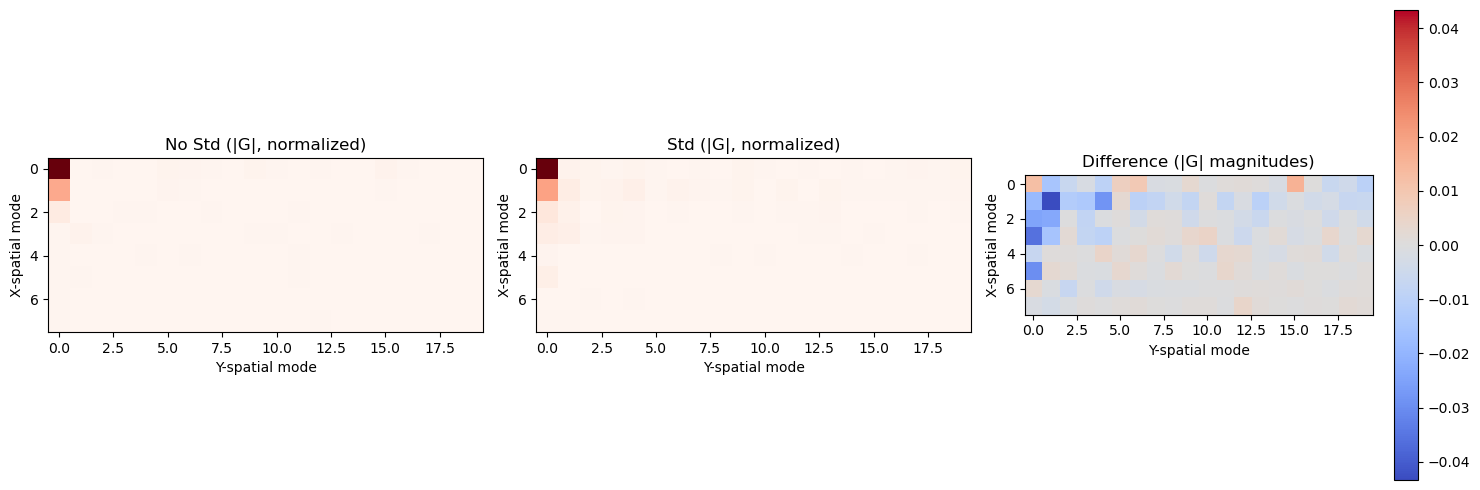

In [93]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Use absolute values for fair comparison
spatial_coupling_nostd_abs = np.abs(spatial_coupling_nostd)
spatial_coupling_std_abs = np.abs(spatial_coupling_std)

# Normalize by Frobenius norm
norm_nostd = np.linalg.norm(spatial_coupling_nostd_abs, 'fro')
norm_std = np.linalg.norm(spatial_coupling_std_abs, 'fro')

axes[0].imshow(spatial_coupling_nostd_abs / norm_nostd, cmap='Reds')  # Use 'Reds' for positive-only
axes[0].set_xlabel('Y-spatial mode')
axes[0].set_ylabel('X-spatial mode')
axes[0].set_title("No Std (|G|, normalized)")

axes[1].imshow(spatial_coupling_std_abs / norm_std, cmap='Reds')
axes[1].set_xlabel('Y-spatial mode')
axes[1].set_ylabel('X-spatial mode')
axes[1].set_title("Std (|G|, normalized)")

# Difference in magnitudes
diff = (spatial_coupling_nostd_abs / norm_nostd) - (spatial_coupling_std_abs / norm_std)
im = axes[2].imshow(diff, cmap='coolwarm', vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)))
axes[2].set_xlabel('Y-spatial mode')
axes[2].set_ylabel('X-spatial mode')
axes[2].set_title("Difference (|G| magnitudes)")
plt.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.show()

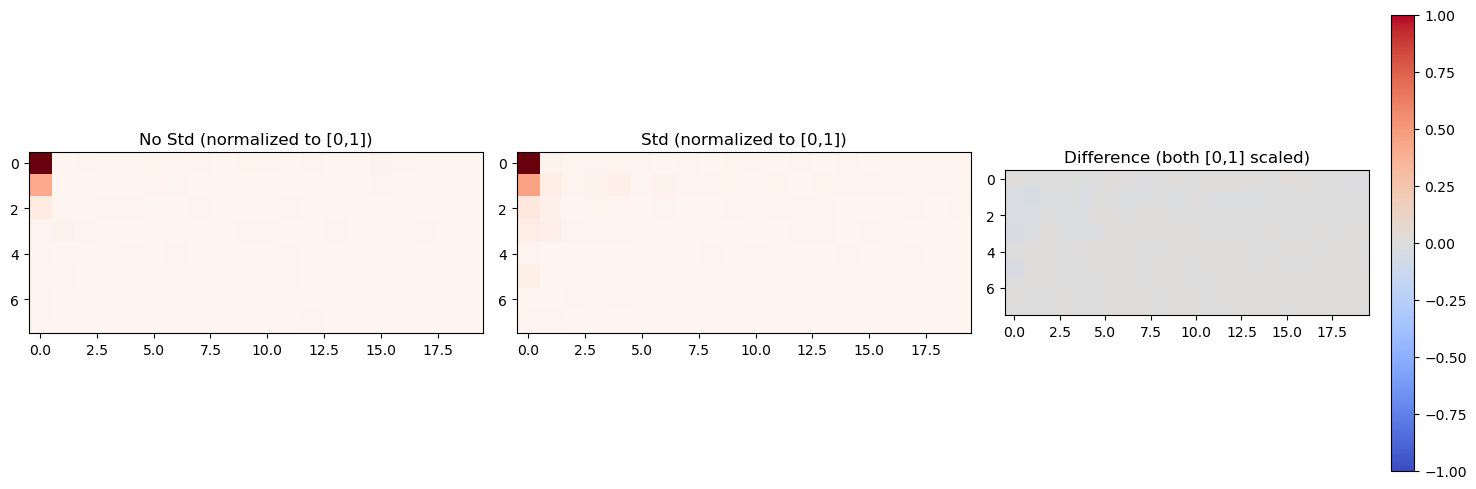

In [99]:
def normalize_matrix_01(M):
    """Normalize all elements to [0, 1] range"""
    M_min = np.min(M)
    M_max = np.max(M)
    
    if M_max == M_min:
        return np.zeros_like(M)
    
    return (M - M_min) / (M_max - M_min)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Method 1: Normalize each separately (shows internal structure)
G_nostd_norm = normalize_matrix_01(np.abs(spatial_coupling_nostd))
G_std_norm = normalize_matrix_01(np.abs(spatial_coupling_std))

axes[0].imshow(G_nostd_norm, cmap='Reds', vmin=0, vmax=1)
axes[0].set_title("No Std (normalized to [0,1])")

axes[1].imshow(G_std_norm, cmap='Reds', vmin=0, vmax=1)
axes[1].set_title("Std (normalized to [0,1])")

# Method 2: Difference (now both on same scale)
diff = G_nostd_norm - G_std_norm
im = axes[2].imshow(diff, cmap='coolwarm', vmin=-1, vmax=1)
axes[2].set_title("Difference (both [0,1] scaled)")
plt.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.show()

In [ ]:
print(np.(spatial_coupling_nostd, spatial_coupling_std))

False
